The code below implements Random Network Distillation (RND) plus Proximal Policy Optimization (PPO) with the following (probably an overkill) to solve Pendulum-v0:

1.  Fast-slow LSTM  
2.  VAE like "variational unit" (VU) where it's latent variable is used with the RND predictor network.

The purpose of 1 & 2 is to experiment & mimic an **overly simplified** version of a "recurrent processing with temporal hierarchy" with "variational unit" as described in [(1)](https://arxiv.org/pdf/1807.01281.pdf).













#Switch directory, install & use tensorflow==1.15.2.

In [1]:
# switch directory in Google drive for saving checkpoint
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/reinforcement_learning/RND/"
!pwd

!pip3 install tensorflow==1.15.2    # install & use tensorflow==1.15.2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/reinforcement_learning/RND
/content/gdrive/My Drive/Colab Notebooks/reinforcement_learning/RND


#Imports

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import itertools

#Global variables

In [3]:
EP_MAX = 800
EP_LEN = 200 #128

sample_size = 10000

ext_r_coeff = 2.0   # extrinsic reward coefficient
int_r_coeff = 1.0   # intrinsic reward coefficient
c_loss_coeff = 0.5  # coefficient for total critic loss

next_s_CLIP = 5.0   # clip for next state's buffer
r_CLIP = 1.0    # clip for extrinsic reward, note that intrinsic rewards are not clip.
grad_clip = 5.0   # to prevent LSTM from exploding or vanishing gradient

# more encoding features means more difficult for predictor to predict correctly which also means more/greater exploration bonus.
encode_features = 3000    # number of output for RND predictor's network

# Hyper parameters for computation of TD lambda return and policy advantage using GAE
GAMMA = 0.9   # discount factor for extrinsic reward
GAMMA_i = 0.9   # discount factor for intrinsic reward
lamda = 0.95    # smoothing factor for GAE

# PPO Hyper parameters
TL_LR = 0.0001 
BATCH = 32 
EPOCH = 10  
epsilon = 0.1
ENTROPY_BETA = 0.001

cell_size = 25
hidden = 50
latent_dim = cell_size

chkpt_freq = 300
is_chkpt = False 
is_restore = False 
chkpt_num = 90

game_name = 'Pendulum-v0'
env = gym.make(game_name).unwrapped
S_DIM, next_S_DIM, A_DIM = env.observation_space.shape[0], env.observation_space.shape[0], env.action_space.shape[0] 
state_next_normal = True    # normalize s_ for RND's target & predictor networks

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

all_steps = [] # stores number of episodic steps for display
all_ep_r = [] # stores raw episodic rewards for display
mv_all_ep_r = [] # store moving average episodic rewards for display

hit_counter = 0 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#Fast-slow LSTM (VU)

The means & sigmas are extracted from the slow LSTM core & the last fast LSTM core. 

They are used to compute P (prior distribution), Q (posterior distribution), z (latent variable used in RND predictor network) & the KL-divergence between P & Q. 

The KL-divergence is added to the total loss in the optimizer (minimize the KL-divergence).


In [0]:
class FS_LSTM_VU(tf.compat.v1.nn.rnn_cell.RNNCell):
    def __init__(self, fast_cells, slow_cell):
        """     
        This code works in tensorflow 1.15.2 & is adapted & modified from:
            https://github.com/amujika/Fast-Slow-LSTM/blob/master/FSRNN.py

        The means & sigmas are extracted from the slow-LSTM core (P) & the last fast-LSTM core (Q).      
        """
        self.fast_cells = fast_cells
        self.slow_cell = slow_cell
        self.S_mean = None
        self.S_sigma = None
        self.F_mean = None
        self.F_sigma = None

    def __call__(self, inputs, state, scope='fast-slow-LSTM'):
        F_state = state[0]
        S_state = state[1]
        w = tf.random_normal_initializer(seed=10)

        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            with tf.variable_scope('Fast_0'):
                F_output, F_state = tf.nn.dynamic_rnn(cell=self.fast_cells[0], inputs=inputs, initial_state=F_state, time_major=True)
            with tf.variable_scope('Slow_P'):
                S_output, S_state = tf.nn.dynamic_rnn(cell=self.slow_cell[0], inputs=F_output, initial_state=S_state, time_major=True)   
            self.S_mean = tf.layers.dense(S_output, latent_dim, activation=None, kernel_initializer = w, name='mean_P', trainable=True) 
            self.S_sigma = tf.layers.dense(S_output, latent_dim, tf.nn.softplus, kernel_initializer = w, name='sigma_P', trainable=True) 
            with tf.variable_scope('Fast_1'):
                F_output, F_state = tf.nn.dynamic_rnn(cell=self.fast_cells[1], inputs=S_output, initial_state=F_state, time_major=True)
            for i in range(len(self.slow_cell)+1, len(self.fast_cells)):
                with tf.variable_scope('Fast_' + str(i)):
                    F_output, F_state = tf.nn.dynamic_rnn(cell=self.fast_cells[i], inputs=F_output, initial_state=F_state, time_major=True)
            self.F_mean = tf.layers.dense(F_output, latent_dim, activation=None, kernel_initializer = w, name='mean_Q', trainable=True) 
            self.F_sigma = tf.layers.dense(F_output, latent_dim, tf.nn.softplus, kernel_initializer = w, name='sigma_Q', trainable=True) 

            return F_output, (F_state, S_state), (self.S_mean, self.S_sigma), (self.F_mean, self.F_sigma)

    def zero_state(self, batch_size, dtype):
        F_state = self.fast_cells[0].zero_state(batch_size, dtype)
        S_state = self.slow_cell[0].zero_state(batch_size, dtype)

        return (F_state, S_state)

#RunningStats class

In [0]:
class RunningStats(object):
    # This class which computes global stats is adapted & modified from:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)
        self.count = batch_count + self.count        

#RND_PPO class

In [0]:
class RND_PPO(object):            
    def __init__(self):
        self.sess = tf.Session()
        self.s = tf.placeholder(tf.float32, [None, S_DIM], 'state')
        self.s_ = tf.placeholder(tf.float32, [None, next_S_DIM], 'state_')   
        self.activation = tf.nn.relu
        self.RND_target_w_init = tf.random_normal_initializer
        self.w_init = tf.glorot_uniform_initializer()

        # RDN        
        with tf.variable_scope('target'):
            # Fixed target network encodes state to features        
            # Network randomly initialized but never trained, params remain fixed, trainable=False           
            hidden_layer = tf.layers.dense(self.s_, hidden, self.activation, kernel_initializer=self.RND_target_w_init, name='t_hidden', trainable=False)
            self.target_out = tf.layers.dense(hidden_layer, encode_features, kernel_initializer=self.RND_target_w_init, name='target_out', trainable=False)
        with tf.variable_scope('predictor'):
            lstm_out, final_state, self.F_norm_dist_sample_z, self.KL = self._fs_lstm_vu(self.s_, cell_size)    # fast-slow LSTM with VU
            hidden_layer = tf.layers.dense(self.F_norm_dist_sample_z, hidden, self.activation, kernel_initializer=self.w_init, name='p_hidden', trainable=True)
            self.predictor_out = tf.layers.dense(hidden_layer, encode_features, kernel_initializer=self.w_init, name='predictor_out', trainable=True)
        with tf.variable_scope('predictor_loss'):
            self.predictor_loss = tf.reduce_sum(tf.square(self.target_out - self.predictor_out), axis=1)
  
        # critic
        with tf.variable_scope('ext_critic'):
            hidden_layer = tf.layers.dense(self.s, hidden, self.activation, kernel_initializer=self.w_init, name='c_e_hidden', trainable=True)
            self.v = tf.layers.dense(hidden_layer, 1, name='val', trainable=True)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
        with tf.variable_scope('int_critic'):   # intrinsic
            hidden_layer = tf.layers.dense(self.s, hidden, self.activation, kernel_initializer=self.w_init, name='c_i_hidden', trainable=True)
            self.v_i = tf.layers.dense(hidden_layer, 1, name='val_i', trainable=True)                      
            self.tfdc_r_i = tf.placeholder(tf.float32, [None, 1], 'discounted_r_i')
            self.advantage_i = self.tfdc_r_i - self.v_i
            self.closs_i = tf.reduce_mean(tf.square(self.advantage_i))
        with tf.variable_scope('critic_total_loss'):
            self.total_closs = self.closs + self.closs_i
            
        # actor            
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)    # trainable=False        
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)   # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]
        with tf.variable_scope('surrogate_loss'):
            self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
            self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
            ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
            surr = ratio * self.tfadv           
            self.aloss = -tf.reduce_mean(tf.minimum(surr, 
                                                    tf.clip_by_value(ratio, 1.-epsilon, 1.+epsilon) * self.tfadv))
        with tf.variable_scope('entropy'):                
            entropy = -tf.reduce_mean(pi.entropy())   # Compute the differential entropy of the multivariate normal.   

        with tf.variable_scope('total_loss'):
            self.total_loss = tf.reduce_mean(self.predictor_loss + self.total_closs * c_loss_coeff + self.aloss + entropy * ENTROPY_BETA + tf.reduce_mean(self.KL) + 1e-20)            
        with tf.variable_scope('train'):
            #self.train_op = tf.train.AdamOptimizer(TL_LR).minimize(self.total_loss)            
            optimizer = tf.train.AdamOptimizer(TL_LR)
            gradients, variables = zip(*optimizer.compute_gradients(self.total_loss))
            gradients, _ = tf.clip_by_global_norm(gradients, grad_clip)
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))                 
        with tf.variable_scope('sess_global_variables_initializer'):
            self.sess.run(tf.global_variables_initializer())

    def intrinsic_r(self, s_):
        return self.sess.run(self.predictor_loss, {self.s_: s_})
        
    def _build_anet(self, name, trainable):
        """
        tanh range = [-1,1]
        softplus range = {0,inf}             
        """
        with tf.variable_scope(name):          
            hidden_layer = tf.layers.dense(self.s, hidden, self.activation, kernel_initializer=self.w_init, name='a_hidden', trainable=trainable)
            mu = env.action_space.high * tf.layers.dense(hidden_layer, A_DIM, tf.nn.tanh, kernel_initializer=self.w_init, name='mu', trainable=trainable)
            sigma = tf.layers.dense(hidden_layer, A_DIM, tf.nn.softplus, kernel_initializer=self.w_init, name='sigma', trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.s: s})[0]
        return np.clip(a, env.action_space.low, env.action_space.high)
      
    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.s: s})[0, 0]
      
    def get_v_i(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v_i, {self.s: s})[0, 0]
      
    def add_vtarg_and_adv(self, R, done, V, v_s_, gamma, lam):
        # Compute target value using TD(lambda) estimator, and advantage with GAE(lambda)
        # last element is only used for last vtarg, but we already zeroed it if last new = 1
        done = np.append(done, 0)
        V_plus = np.append(V, v_s_)
        T = len(R)
        adv = gaelam = np.empty(T, 'float32')
        lastgaelam = 0
        for t in reversed(range(T)):
            nonterminal = 1-done[t+1]        
            delta = R[t] + gamma * V_plus[t+1] * nonterminal - V_plus[t]
            gaelam[t] = lastgaelam = delta + gamma * lam * nonterminal * lastgaelam   
        tdlamret = np.vstack(adv) + V
        return tdlamret, adv # tdlamret is critic_target or Qs              

    def update(self, s, s_, a, r, r_i, adv):
        self.sess.run(self.update_oldpi_op)
        [self.sess.run(self.train_op, {self.s: s, self.tfa: a, self.tfadv: adv, self.tfdc_r: r, self.tfdc_r_i: r_i, self.s_: s_}) for _ in range(EPOCH)]

    def _fs_lstm_vu(self, Inputs, cell_size):       
        """
        Create the fast-slow LSTM cores.
        Compute the variational units (VU): P, Q, z & the KL divergence.
        """
        s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature] = [?,1,2]

        #Create one Slow and three Fast cells
        slow = [tf.nn.rnn_cell.LSTMCell(cell_size)]
        fast = [tf.nn.rnn_cell.LSTMCell(cell_size),
                tf.nn.rnn_cell.LSTMCell(cell_size),
                tf.nn.rnn_cell.LSTMCell(cell_size)]

        #Create a single FS-RNN using the cells
        fs_lstm_vu = FS_LSTM_VU(fast, slow)

        #Get initial state and create tf op to run one timestep
        init_state = fs_lstm_vu.zero_state(batch_size=1, dtype=tf.float32)    # batch_size
        output, final_state, S_N_args, F_N_args = fs_lstm_vu(s, init_state)

        S_norm_dist = tf.distributions.Normal(loc=S_N_args[0], scale=S_N_args[1])   # P, prior distribution from the slow LSTM core
        F_norm_dist = tf.distributions.Normal(loc=F_N_args[0], scale=F_N_args[1])   # Q, posterior distribution from the fast LSTM core
        F_norm_dist_sample_z = tf.squeeze(F_norm_dist.sample(1), axis=0)    # sample latent var z
        KL = tf.distributions.kl_divergence(S_norm_dist, F_norm_dist)   # KL to be added to loss function, try to minimize KL   

        output = tf.reshape(output, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
        F_norm_dist_sample_z = tf.reshape(F_norm_dist_sample_z, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation

        return output, final_state, F_norm_dist_sample_z, KL

#Helper functions

In [0]:
# pre-train updating of s_ to running_stats_s_ object to prepare for normalization
def state_next_normalize(sample_size, running_stats_s_):  
  buffer_s_ = []
  s = env.reset()  
  for i in range(sample_size):
    a = env.action_space.sample()
    s_, r, done, _ = env.step(a)   
    buffer_s_.append(s_)    
  running_stats_s_.update(np.array(buffer_s_))

In [0]:
# normalize & clip a running buffer
# used on extrinsic reward (buffer_r), intrinsic reward (buffer_r_i) & next state(s_)
def running_stats_fun(run_stats, buf, clip, clip_state):
    run_stats.update(np.array(buf))
    buf = (np.array(buf) - run_stats.mean) / run_stats.std   
    if clip_state == True:
      buf = np.clip(buf, -clip, clip)
    return buf

#Preprocess: next state normalization

In [0]:
# normalization objects
running_stats_s = RunningStats()
running_stats_s_ = RunningStats()
running_stats_r = RunningStats()
running_stats_r_i = RunningStats()

if state_next_normal == True:
    state_next_normalize(sample_size, running_stats_s_) 

#Setup for saving/restore checkpoint 

In [10]:
rnd_ppo = RND_PPO()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

if is_restore == True:
    path = "./chkpt/model_{}.ckpt".format(chkpt_num)
    saver.restore(rnd_ppo.sess, path)
    print("chkpt {} restored.".format(path)) 

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `t

#Train

In [11]:
start_time = time.time()    


for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
    ep_r = 0
    ep_r_clip = 0
    ep_r_i = 0
    steps = 0
    for t in range(EP_LEN):    # in one episode
        #env.render()               
        a = rnd_ppo.choose_action(s)
        s_, r, done, _ = env.step(a)
                
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append(r)    
        buffer_s_.append(s_)
        buffer_done.append(done)                  
        
        v = rnd_ppo.get_v(s)
        buffer_V.append(v)  
        v_i = rnd_ppo.get_v_i(s)
        buffer_V_i.append(v_i)  
        
        s = s_
        ep_r += r
        steps += 1                            
        
        # update rnd_ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            if state_next_normal == True:
                buffer_s_ = running_stats_fun(running_stats_s_, buffer_s_, next_s_CLIP, True)   # normalize & clip next s, do nothing to s

            buffer_r_i = rnd_ppo.intrinsic_r(buffer_s_)
            buffer_r = running_stats_fun(running_stats_r, buffer_r, r_CLIP, True)   
            buffer_r_i = running_stats_fun(running_stats_r_i, buffer_r_i, r_CLIP, False)    # normalize intrinsic r, don't clip

            ep_r_clip = ep_r_clip + np.mean(buffer_r)
            ep_r_i = ep_r_i + np.mean(buffer_r_i)
            
            v_s_ = rnd_ppo.get_v(s_)                                 
            tdlamret, adv = rnd_ppo.add_vtarg_and_adv(np.vstack(buffer_r), np.vstack(buffer_done), np.vstack(buffer_V), 
                                                      v_s_, GAMMA, lamda)
            v_s_i = rnd_ppo.get_v_i(s_)                     
            tdlamret_i, adv_i = rnd_ppo.add_vtarg_and_adv(np.vstack(buffer_r_i), np.vstack(buffer_done), np.vstack(buffer_V_i), 
                                                          v_s_i, GAMMA_i, lamda)

            bs, bs_, ba, br, br_i, b_adv = np.vstack(buffer_s), np.vstack(buffer_s_), np.vstack(buffer_a), tdlamret, tdlamret_i, np.vstack(ext_r_coeff * adv + int_r_coeff * adv_i) # sum advantages
            buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
            rnd_ppo.update(bs, bs_, ba, br, br_i, b_adv)
            
        if done:            
            print('done', ep, steps, ep_r, ep_r_clip, ep_r_i) 
            break               

    # for saving checkpoint
    if is_chkpt == True and ep % chkpt_freq == 0:
        path = "./chkpt/model_{}.ckpt".format(ep)
        save_path = saver.save(rnd_ppo.sess, path)
        print("checkpoint saved at: %s" % save_path)

    # for plotting
    if ep == 0: 
        mv_all_ep_r.append(ep_r)
    else: 
        mv_ep_r = mv_all_ep_r[-1]*0.9 + ep_r*0.1
        print('          mv_ep_r', mv_ep_r, ep)        
        mv_all_ep_r.append(mv_ep_r)       
      
    all_ep_r.append(ep_r)      
    all_steps.append(steps)                        


print("--- %s seconds ---" % (time.time() - start_time))    

          mv_ep_r -1821.0321867604462 1
          mv_ep_r -1804.670486173989 2
          mv_ep_r -1812.2312921316197 3
          mv_ep_r -1805.2125404544004 4
          mv_ep_r -1799.0162906904245 5
          mv_ep_r -1803.7482596688712 6
          mv_ep_r -1800.2851410249516 7
          mv_ep_r -1789.0943957406894 8
          mv_ep_r -1792.5110185820427 9
          mv_ep_r -1773.537019605521 10
          mv_ep_r -1751.0551157875173 11
          mv_ep_r -1754.3166108893515 12
          mv_ep_r -1725.7699741696995 13
          mv_ep_r -1720.0523691111136 14
          mv_ep_r -1729.6304587596567 15
          mv_ep_r -1704.2744133281335 16
          mv_ep_r -1712.4201148903012 17
          mv_ep_r -1687.3022900903995 18
          mv_ep_r -1693.913076922206 19
          mv_ep_r -1661.647475449368 20
          mv_ep_r -1625.9512927383016 21
          mv_ep_r -1623.6215980586323 22
          mv_ep_r -1591.4458479515956 23
          mv_ep_r -1559.4036078051952 24
          mv_ep_r -1539.58614

#Plot result

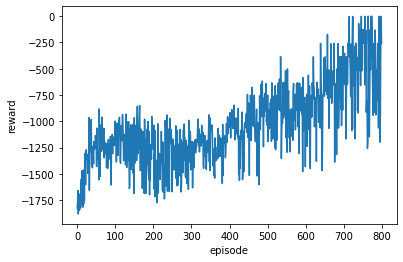

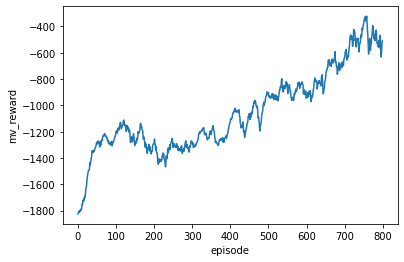

In [12]:
plt.plot(all_ep_r)
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

plt.plot(mv_all_ep_r)
plt.ylabel("mv_reward")
plt.xlabel("episode")
plt.show()

#References:

(1) [Human-level performance in first-person multiplayer
games with population-based deep reinforcement
learning](https://arxiv.org/pdf/1807.01281.pdf)

(2) [Fast-Slow Recurrent Neural Networks](https://arxiv.org/pdf/1705.08639.pdf)